<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/k2_pix_small.png">
*This notebook contains an excerpt instructional material from [gully](https://twitter.com/gully_) and the [K2 Guest Observer Office](https://keplerscience.arc.nasa.gov/); the content is available [on GitHub](https://github.com/gully/goldenrod).*


<!--NAVIGATION-->
< [Metadata and preliminaries](01.00-Metadata-and-preliminaries.ipynb) | [Contents](Index.ipynb) | [Custom tile target apertures on galaxies](01.02-Custom-tile-apertures-on-galaxies.ipynb) >

# KEGS metadata and sample overview

Most of the extragalactic data comes from the `KEGS` team Guest Observer proposals.  Information associated proposals is online and easily accesible.  We can find most galaxies just by searching the Kepler Science target proposals site titles including "KEGS".  This search process is non exhaustive, since other Guest Observer proposals targeting particular galaxies, e.g. for AGN, might escape such a simple search.

Here is a list of KEGS programs targeting galaxies.

| Program | Description |
|--|--|
|GO0103| THE KEPLER EXTRA-GALACTIC SURVEY (KEGS): SUPERNOVAE, AGN, QSOS AND BL LACS |
|GO1074| The Kepler Extra-Galactic Survey (KEGS) |
|GO3048| The Kepler Extra-Galactic Survey (KEGS) Transient Survey; Campaign 3 |
|GO4096| The K2 Extra-Galactic Survey (KEGS)Transient Survey; Cycle 1 |
|GO5096| The K2 Extra-Galactic Survey (KEGS)Transient Survey; Cycle 1 |
|GO6077| The K2 Extra-Galactic Survey (KEGS) Transient Survey |
|GO8070| The K2 Extragalactic Survey (KEGS) for Transients |
|GO8053| The K2 Extragalactic Survey (KEGS) in Nearby Galaxies: Cycle 3 |
|GO10070| The K2 Extragalactic Survey (KEGS) for Transients |
|GO10053| The K2 Extragalactic Survey (KEGS) in Nearby Galaxies: Cycle 3|
|GO12116| The K2 Extragalactic Survey (KEGS) for Transients |
|GO12068| The K2 Extragalactic Survey (KEGS) in Nearby Galaxies: Cycle 4|
|GO14079| The K2 ExtraGalactic Survey (KEGS) for Transients |
|GO14078| The K2 Extragalactic Survey (KEGS) in Nearby Galaxies: Cycle 5|

Let's explore the metadata of these programs to understand what the data look like.

In [1]:
import pandas as pd

You will need the [k2-target-index repository](https://github.com/barentsen/k2-target-index) and [K2-metadata repository](https://github.com/gully/k2-metadata) saved locally on your computer.  You can adjust the paths to wherever you have them stored locally.

In [2]:
targ_index_path = '../../k2-target-index/k2-target-pixel-files.csv.gz'
K2_GO_metadata_path = '../../K2-metadata/metadata/tidy/GO_proposal_metadata.csv'

The k2-target-index file is large enough to take a few seconds to read the whole thing with pandas.

In [3]:
%time df_targ = pd.read_csv(targ_index_path)

CPU times: user 12.6 s, sys: 927 ms, total: 13.5 s
Wall time: 13 s


Sub-campaigns are sometimes indexed by strings (*e.g.* '9a' and '9b' or integers '91' and '92').  See section 1 of the [K2 Handbook](http://archive.stsci.edu/k2/manuals/k2_handbook.pdf) for more information about the campaign naming scheme. We'll rename one of the columns in anticipation of ambiguity...

In [4]:
df_targ.rename(columns={'campaign':'campaign_num'}, inplace=True)

In [5]:
df_GO = pd.read_csv(K2_GO_metadata_path, dtype={'campaign':str}, usecols=['EPIC ID','Investigation IDs', 'campaign'])
df_GO.shape

(426130, 3)

In [6]:
df_GO.columns

Index(['EPIC ID', 'Investigation IDs', 'campaign'], dtype='object')

The column `'Investigation IDs'` is a *pipe-delimited* list of the Guest Observer identifications of proposals.

In [7]:
df_GO['Investigation IDs'].iloc[34010:34015]

34010                         GO2054_LC|GO2104_LC
34011                                   GO2051_LC
34012                                   GO2051_LC
34013     GO2054_LC|GO2080_LC|GO2101_LC|GO2104_LC
34014                                   GO2069_LC
Name: Investigation IDs, dtype: object

A straightforward pandas string search will yield a boolean series of whether the target was requested by KEGS.

In [8]:
KEGS_ids = ['GO14078','GO14079','GO12068','GO12116','GO10053','GO10070',
            'GO8053','GO8070','GO6077','GO5096','GO4096','GO3048','GO1074','GO0103']

We will use a regular expression search pattern:

In [9]:
search_pattern = '|'.join(KEGS_ids)
search_pattern

'GO14078|GO14079|GO12068|GO12116|GO10053|GO10070|GO8053|GO8070|GO6077|GO5096|GO4096|GO3048|GO1074|GO0103'

The pipe symbols, `|` , in this search pattern are not matched; instead they represent an "or" operator, allowing a match to any of these substrings to register as "`True`".

In [10]:
df_GO['KEGS_target'] = df_GO['Investigation IDs'].str.contains(search_pattern)

The sum of the boolean values tells us how many proposals were targeted by KEGS.

In [11]:
df_GO.KEGS_target.sum()

40127

Let's drop all the non-KEGS sources with a boolean mask.

In [12]:
df_GO = df_GO[df_GO.KEGS_target]

In [13]:
df_GO.head()

,EPIC ID,Investigation IDs,campaign,KEGS_target
235,202059522,GO0009_LC|GO0035_LC|GO0061_LC|GO0074_LC|GO010...,0,True
252,202060054,GO0013_LC|GO0063_LC|GO0075_LC|GO0077_LC|GO010...,0,True
508,202062048,GO0035_LC|GO0103_LC|GO0106_LC,0,True
2667,202074356,GO0103_LC|GO0106_LC,0,True
2668,202074357,GO0103_LC|GO0106_LC,0,True


Let's merge the Guest Observer proposals with all the metadata about the targets.

In [14]:
df_comb = pd.merge(df_GO, df_targ, how='left', left_on='EPIC ID', right_on='keplerid')

In [15]:
df_comb.keplerid.isnull().sum(), df_comb.keplerid.notnull().sum()

(14640, 30399)

Some KEGS galaxies are not in the K2 target index, mainly because campaign 14 was not yet processesed at the time the k2-target-index was created.  Some also have custom large apertures that might affect the TPF metadata.

In [16]:
df_GO.groupby('campaign').KEGS_target.sum()[df_GO.campaign.unique()]

campaign
0       106.0
1      2985.0
3      4144.0
4       761.0
5      2801.0
6      4680.0
8      2661.0
10     4892.0
12     2457.0
14    14640.0
Name: KEGS_target, dtype: float64

In [17]:
df_comb.groupby('campaign_num').KEGS_target.sum()

campaign_num
0.0       106.0
1.0      2987.0
3.0      4144.0
4.0       762.0
5.0      2802.0
6.0      4680.0
8.0      2661.0
12.0     2457.0
13.0        5.0
101.0    4898.0
102.0    4897.0
Name: KEGS_target, dtype: float64

Slight differences, but mainly the same.  Campaign 14 is not yet in our target index.

Let's see how the KEGS targets compare to typical K2 targets in terms of number of pixels and target magnitude.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
df_comb.npix.median()

121.0

The typical KEGS target has about 121 pixels.  
However, this estimate could include "tiles" designed for extending large patches of pixels on oversized galaxies.

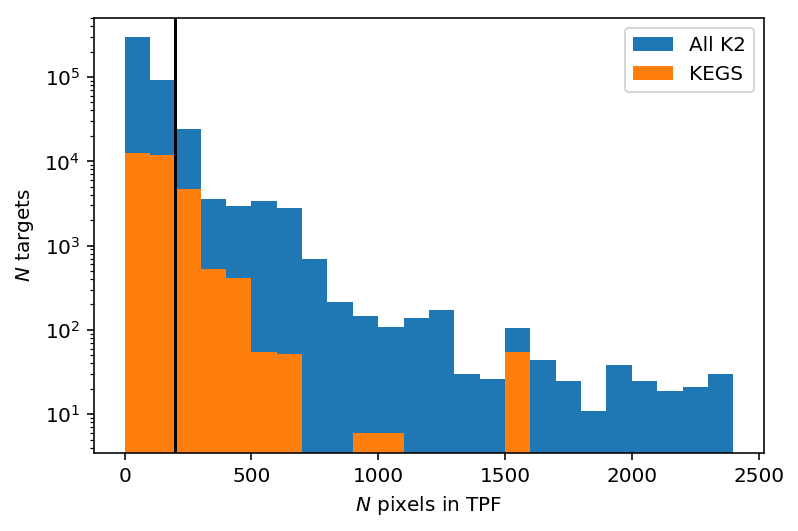

In [20]:
plt.hist(df_targ.npix[df_targ.npix.notnull()], bins=np.arange(0,2500, 100), label='All K2')
plt.hist(df_comb.npix[df_comb.npix.notnull()], bins=np.arange(0,2500, 100), label='KEGS')
plt.yscale('log')
plt.xlabel('$N$ pixels in TPF')
plt.ylabel('$N$ targets')
plt.axvline(200, color='k')
plt.legend();

In [21]:
df_comb.obsmode.value_counts()

long cadence     30397
short cadence        2
Name: obsmode, dtype: int64

There are aparently 2 galaxies that received short cadence observations.

In [22]:
df_comb[df_comb.obsmode == 'short cadence']['Investigation IDs'].values

array([' GO4102_SC|GO4029_LC|GO4096_LC|GO4102_LC',
       ' GO5038_SC|GO5053_LC|GO5056_LC|GO5096_LC|GO5038_LC'], dtype=object)

One (EPIC 210510422) is from a proposal to study M dwarfs (GO4102)... what!?  
The other is from an AGN proposal (GO5038_SC), aimed at the "rapidly-variable blazar OJ 287".

What's the deal with the M dwarf??

In [24]:
df_comb[df_comb['EPIC ID'] == 210510422].T

,7485,7486
EPIC ID,210510422,210510422
Investigation IDs,GO4102_SC|GO4029_LC|GO4096_LC|GO4102_LC,GO4102_SC|GO4029_LC|GO4096_LC|GO4102_LC
campaign,4,4
KEGS_target,True,True
filename,ktwo210510422-c04_spd-targ.fits.gz,ktwo210510422-c04_lpd-targ.fits.gz
url,http://archive.stsci.edu/missions/k2/target_pi...,http://archive.stsci.edu/missions/k2/target_pi...
filesize,892.4,30.7
object,EPIC 210510422,EPIC 210510422
keplerid,2.1051e+08,2.1051e+08
obsmode,short cadence,long cadence


It's a bright, nearby M dwarf, and appears to have no galaxy near it at all!  Perhaps the KEGS team put the target on accidentally, or for purposes of calibration.

`210510422, 57.220444, 15.5858, 8.37, GO4102_SC|GO4029_LC|GO4096_LC|GO4102_LC`

What's the distribution of Kepmag for KEGS sources?

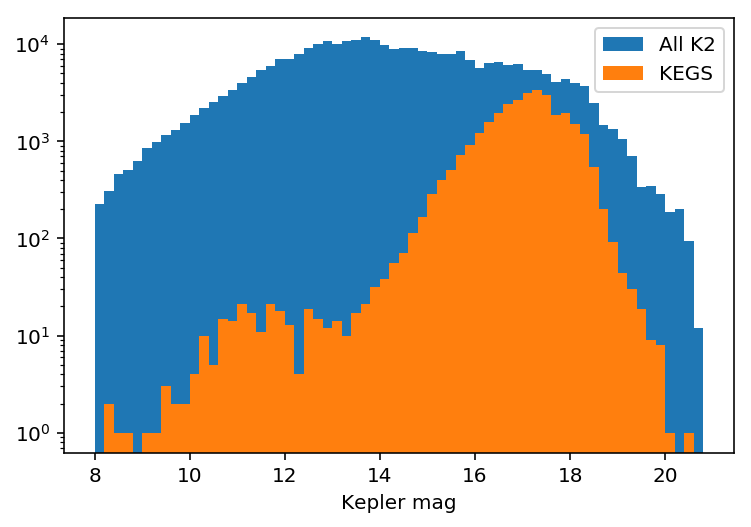

In [25]:
plt.hist(df_targ.kepmag[df_targ.kepmag.notnull()], bins=np.arange(8,21, 0.2), label='All K2')
plt.hist(df_comb.kepmag[df_comb.kepmag.notnull()], bins=np.arange(8,21, 0.2), label='KEGS')
plt.yscale('log')
plt.xlabel('Kepler mag')
plt.legend();

KEGS targets tend to be fainter than the typical K2 target, but they're also *extended* compared to stellar targets...

<!--NAVIGATION-->
< [Metadata and preliminaries](01.00-Metadata-and-preliminaries.ipynb) | [Contents](Index.ipynb) | [Custom tile target apertures on galaxies](01.02-Custom-tile-apertures-on-galaxies.ipynb) >